# Analyse de sensibilité globale par régression - application au cas de la déviation verticale de la poutre


# Model definition

In [1]:
import openturns as ot
import pylab as pl
import math
import openturns.viewer as otv

In [ ]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # in m
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # in m^4
distributionI.setDescription(["I"])

X = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])
X

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 2.2, a = 2.8e+07, b = 4.8e+07)"
1,F,"ParametrizedDistribution(parameters = LogNormalMuSigma(mu = 30000, sigma = 9000, gamma = 15000))"
2,L,"Uniform(a = 250, b = 260)"
3,I,"Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)"


In [3]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un mécanisme d'historique.

In [4]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [5]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (cm)"])

## Régression linéaire avec LinearLeastSquares

In [6]:
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)

myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[0.000367778] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.42462e-07,0.000412573,0.0981488,-0.0332083] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.42462e-07,0.000412573,0.0981488,-0.0332083] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [ ]:
val = ot.MetaModelValidation(sampleY, responseSurface(sampleX))
r2 = val.computeR2Score()[0]
r2

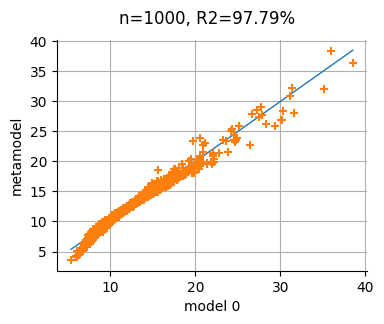

In [9]:
graph = val.drawValidation()
graph.setTitle("n=%d, R2=%.2f%%" % (n, r2 * 100))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On pourrait compléter l'analyse en utilisant un second plan pour la validation, mais il s'avère que cela n'est pas nécessaire dans notre cas particulier. 

On évalue l'échantillon des résidus. Puis on estime les paramètres d'une loi gaussienne dont les paramètres sont ajustés sur l'échantillon des résidus.

hat(sigma) = 0.6381


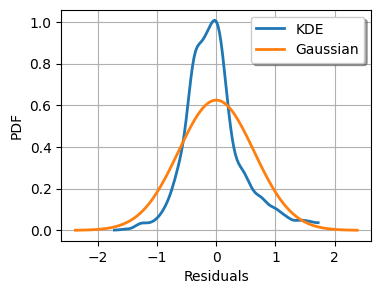

In [ ]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
predicted_outputs = responseSurface(sampleX)
residualsSample = sampleY - predicted_outputs
residualsSample.setDescription(["Residuals"])
sampleSize = sampleX.getSize()
input_dimension = sampleX.getDimension()
n_parameters = 1 + input_dimension
residuals_point = residualsSample.asPoint()
sigma_hat = math.sqrt(residuals_point.normSquare() / (sampleSize - n_parameters))
print("hat(sigma) = %.4f" % (sigma_hat))
noiseEstimated = ot.Normal(0.0, sigma_hat)

graph = ot.KernelSmoothing().build(residualsSample).drawPDF()
graph.setLegends(["KDE"])
curve = noiseEstimated.drawPDF()
curve.setLegends(["Gaussian"])
graph.add(curve)
number_of_graphs = len(graph.getDrawables())
graph.setColors(ot.Drawable().BuildDefaultPalette(number_of_graphs))
graph.setLegendPosition("topright")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

In [11]:
correlationAnalysis = ot.CorrelationAnalysis(sampleX, sampleY)
importance_factors = correlationAnalysis.computeSquaredSRC()
importance_factors

class=Point name=Unnamed dimension=4 values=[0.138209,0.793874,0.00883377,0.0521553]

In [12]:
importance_factors.norm1()

0.9930722218508801

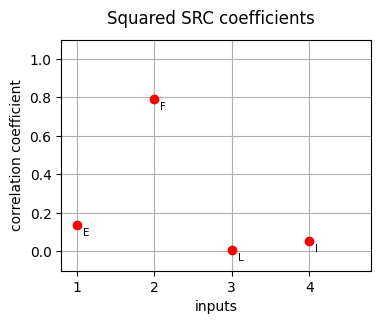

In [13]:
input_names = g.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    importance_factors, input_names, "Squared SRC coefficients"
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Solution de l'exercice 1

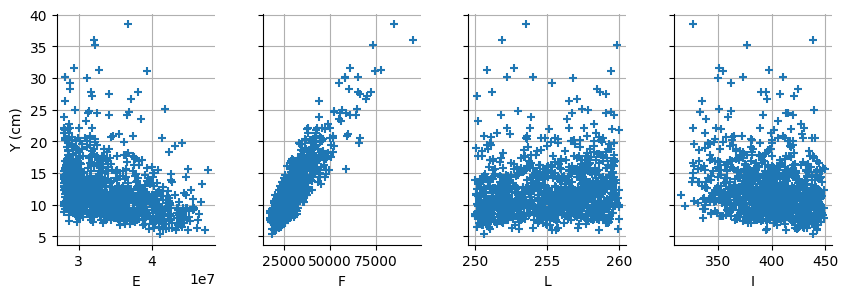

In [14]:
dimX = X.getDimension()
inputdescr = sampleX.getDescription()

grid = ot.VisualTest.DrawPairsXY(sampleX, sampleY)
view = otv.View(grid, figure_kw={"figsize": (10.0, 3.0)})
pl.subplots_adjust(wspace=0.3)

On observe que la dépendance entre Y et F est très forte : 
- les faibles valeurs de F (proches de $0.2\times 10^5$) mènent à une variable Y dont la distribution est entre 0 et 10,
- les fortes valeurs de F (proche de $0.8\times 10^5$) mènent à une variable Y dont la distribution est entre 20 et 40.

On observe au contraire que la variabilité de Y semble indépendante de L. 

## Solution de l'exercice 2 : le coefficient de corrélation de Pearson

In [15]:
sampleXY = ot.Sample(n, 5)
sampleXY[:, 0:4] = sampleX
sampleXY[:, 4] = sampleY

rho = sampleXY.computeLinearCorrelation()
print(rho)

5x5
[[  1            0.0313161   -0.0326608   -0.0011867   -0.346661    ]
 [  0.0313161    1            0.0127222   -0.000199925  0.880595    ]
 [ -0.0326608    0.0127222    1           -0.0481227    0.128456    ]
 [ -0.0011867   -0.000199925 -0.0481227    1           -0.232635    ]
 [ -0.346661     0.880595     0.128456    -0.232635     1           ]]


La dernière ligne de la matrice contient les coefficients qui relient chaque entrée à la sortie. 
- On observe que le plus fort coefficient est égal à 0.89 est celui associé à F, avec un coefficient positif. Le fait que le coefficient est positif est tout à fait évident dans le nuage de points (Y,F) précédent. 
- On observe que le second fort coefficient est égal à -0.33 est celui associé à E, avec un coefficient positif. Le fait que le coefficient est négatif n'est pas si évident dans le nuage de points (Y,E) précédent. 
- Les variables E et I ont des coefficients de corrélation proches et ont dont des effets comparables sur la sortie. 
- Avec un coefficient de corrélation linéaire égal à 0.14, la variable L semble n'avoir aucun impact sur la variabilité de la sortie.

In [16]:
for i in range(4):
    print("rho(Y,%s) = %.4f" % (inputdescr[i], rho[4, i]))

rho(Y,E) = -0.3467
rho(Y,F) = 0.8806
rho(Y,L) = 0.1285
rho(Y,I) = -0.2326


On compare avec `CorrelationAnalysis.computeSRC()`. On obtient des valeurs très proches.

In [17]:
ot.CorrelationAnalysis(sampleX, sampleY).computeSRC()

class=Point name=Unnamed dimension=4 values=[-0.371765,0.890996,0.0939881,-0.228375]

On calcule le carré des coefficients de Pearson. 

In [18]:
squaredPearsonIndices = ot.Point([rho[4, i] ** 2 for i in range(4)])
squaredPearsonIndices

class=Point name=Unnamed dimension=4 values=[0.120174,0.775448,0.0165009,0.0541192]

On compare ensuite avec les coefficients SRC carrés. 

In [19]:
importance_factors

class=Point name=Unnamed dimension=4 values=[0.138209,0.793874,0.00883377,0.0521553]

On observe que les carrés des coefficients sont très proches des facteurs d'importance. Ils seraient égaux si la taille de l'échantillon était infinie. 

En effet, d'un côté l'estimateur du facteur d'importance est :

$$
\widehat{\eta}_i = \frac{\hat{\beta}_i^2 \hat{s}_{x_i}^2}{\hat{s}_y^2}
$$

pour $i=1,\ldots, p$ où $\hat{\beta}_i$ est l'estimateur des moindres carrés linéaires, $\hat{s}_{x_i}^2$ est l'estimateur non biaisé de la variance de l'entrée $x_i$ 
et $\hat{s}_y^2$ est l'estimateur non biaisé de la variance de la sortie $y$ :

$$
\hat{s}_{x_i}^2 = \frac{1}{n - 1} \sum_{i=1}^p \left( x_i^{(j)} - \bar{x}_i \right)^2, \qquad
\hat{s}_y^2 = \frac{1}{n - 1} \sum_{i=1}^p \left( y^{(j)} - \bar{y} \right)^2.
$$

D'un autre côté, le carré du coefficient de corrélation est :

$$
r(Y,X_i)^2 = \frac{\left( \frac{1}{n - 1} \sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)\left(x^{(j)}_i-\bar{x}_i\right)\right)^2}{\hat{s}_y^2 \hat{s}_{x_i}^2}
$$

pour $i=1,2,\ldots,p$.

On observe que la somme de ces carrés n'est pas exactement égale à 1. C'est un résultat attendu, car la somme des carrés des coefficients de Pearson est une variable aléatoire de moyenne égale à 1. Elle fluctue donc de part et d'autre de cette valeur. 

In [20]:
y_hat = responseSurface(sampleX)
sampleYY_hat = ot.Sample(n, 2)
sampleYY_hat[:, 0] = sampleY
sampleYY_hat[:, 1] = y_hat

rho = sampleYY_hat.computeLinearCorrelation()
print(rho)

[[ 1        0.988881 ]
 [ 0.988881 1        ]]


In [21]:
rho[0, 1] ** 2, r2

(0.9778855735978212, 0.9778846452464052)

In [22]:
residual = sampleY - y_hat
SSR = residual.computeRawMoment(2)[0]
SST = sampleY.computeCentralMoment(2)[0]
1.0 - SSR / SST

0.9778846452464052

## Solution de l'exercice 3 : application à une fonction jouet

In [23]:
g = ot.SymbolicFunction(["X1", "X2", "X3"], ["X1 * (X2 - X1) + X3"])
X1 = ot.Normal(0.1, 1)
X2 = ot.Normal(1, 2)
X3 = ot.Normal(2, 0.2)
X = ot.JointDistribution([X1, X2, X3])
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

In [24]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
val = ot.MetaModelValidation(sampleY, responseSurface(sampleX))
q2 = val.computeR2Score()[0]
q2

0.1591731220317949

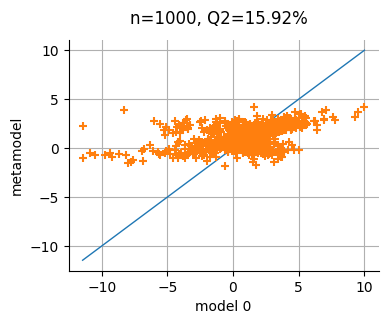

In [25]:
graph = val.drawValidation()
graph.setTitle("n=%d, Q2=%.2f%%" % (n, q2 * 100))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que le métamodèle est de mauvaise qualité. D'une part, le coefficient de prédictivité Q2 est égal à 15%, ce qui est médiocre. D'autre part, le graphique montre que les prédictions du métamodèle sont généralement éloignées du modèle. La cause de ces mauvaises prédictions est que le modèle n'est pas linéaire en fonction des variables d'entrée, ce que le métamodèle ignore. 

In [26]:
ot.CorrelationAnalysis(sampleX, sampleY).computeSquaredSRC()

class=Point name=Unnamed dimension=3 values=[0.127679,0.0113602,0.0168475]

## Solution de l'exercice 4 : modèle de poutre avec distributions élargies

On analyse en détail les changements dans les lois.

| Variable | Paramètres avant | Paramètres après |
|---|---|---|
| E | $a = 2.5\times 10^7$, $b = 5\times 10^7$ | $a = 1.0\times 10^7$, $b = 10.0\times 10^7$ |
| F | $\sigma_F = 9\times 10^3$ | $\sigma_F=20\times 10^3$ |

**Table 1.** Comparaison des paramètres des variables E et F avant et après modification du modèle probabiliste de la poutre encastrée.

On observe que :

- l'intervalle du support de la variable E de loi Beta est plus large ;
- l'écart-type de la variable gaussienne de la loi log-normale sous-jacente pour la variable F est plus grand.

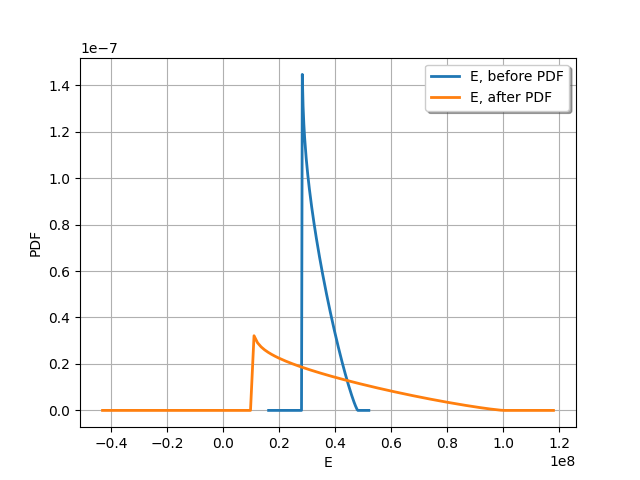

In [27]:
dist_E_before = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E_before.setDescription(["E, before"])
dist_E_after = ot.Beta(0.9, 2.2, 1.0e7, 10.0e7)
dist_E_after.setDescription(["E, after"])
graph = dist_E_before.drawPDF()
curve = dist_E_after.drawPDF()
graph.setXTitle("E")
graph.add(curve)
graph

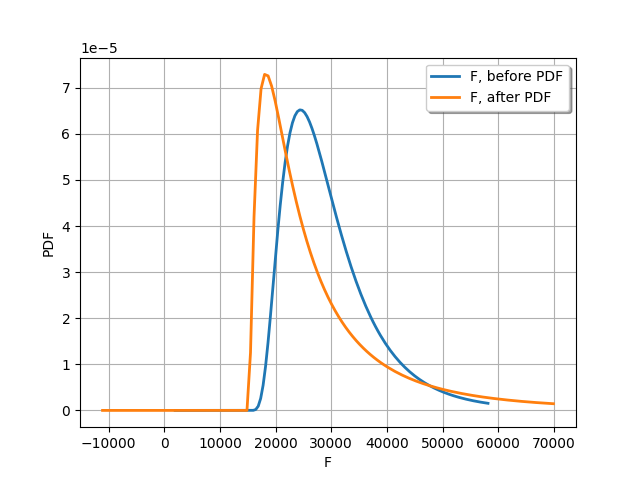

In [28]:
dist_F_before = ot.ParametrizedDistribution(ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3))
dist_F_before.setDescription(["F, before"])
dist_F_after = ot.ParametrizedDistribution(ot.LogNormalMuSigma(3.0e4, 20.0e3, 15.0e3))
dist_F_after.setDescription(["F, after"])
graph = dist_F_before.drawPDF()
curve = dist_F_after.drawPDF()
graph.setXTitle("F")
graph.add(curve)
graph

In [29]:
distributionE = ot.Beta(0.9, 2.2, 1.0e7, 10.0e7)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(3.0e4, 20.0e3, 15.0e3)  # in N
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
X = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
val = ot.MetaModelValidation(sampleY, responseSurface(sampleX))
q2 = val.computeR2Score()[0]
q2

0.7630153889880316

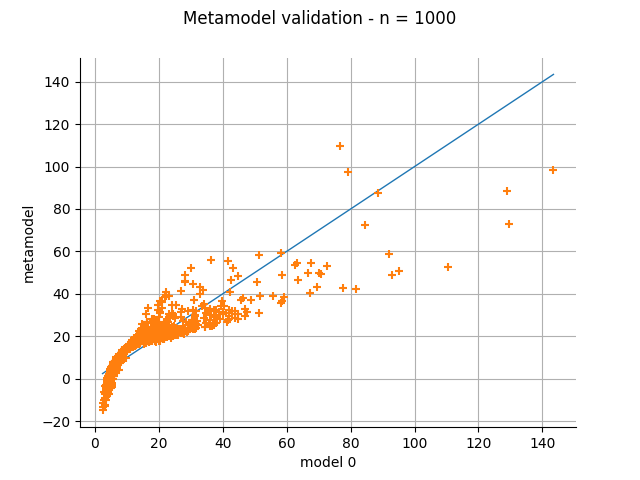

In [30]:
val.drawValidation()

On observe que le coefficient de prédictivité est beaucoup moins proche de 1. Une valeur aussi basse indique que le modèle est moins linéaire que le précédent. La cause de ce changement est l'élargissement du domaine de variation des variables d'entrée, qui prennent plus fréquemment des valeurs éloignées des valeurs centrales. Cela implique un comportement plus éloigné du comportement local que le gradient évalué au point central prédit. En conséquence, on ne peut pas utiliser les indices SRC pour le nouveau modèle.

## Solution de l'exercice 5 : Distribution des indices SRC par bootstrap

In [ ]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # in m
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # in m^4  # in cm^4
distributionI.setDescription(["I"])

X = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

g = ot.MemoizeFunction(g)

XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (cm)"])

sampleSize = 100
dimensionX = X.getDimension()
sampleX = X.getSample(n)
sampleY = g(sampleX)
correlationAnalysis = ot.CorrelationAnalysis(sampleX, sampleY)
squaredSRCindices = correlationAnalysis.computeSquaredSRC()
squaredSRCindices

class=Point name=Unnamed dimension=4 values=[0.137101,0.776203,0.00999714,0.0562926]

In [ ]:
bootstrap_size = 500
squaredSRC_bootstrap = ot.Sample(bootstrap_size, dimensionX)
for i in range(bootstrap_size):
    indices = ot.BootstrapExperiment.GenerateSelection(sampleSize, sampleSize)
    sampleX_bootstrap, sampleY_bootstrap = sampleX[indices], sampleY[indices]
    correlationAnalysis = ot.CorrelationAnalysis(sampleX_bootstrap, sampleY_bootstrap)
    squaredSRC_bootstrap[i, :] = correlationAnalysis.computeSquaredSRC()

# Compute bootstrap quantiles
alpha = 0.05
squaredSRClow = squaredSRC_bootstrap.computeQuantilePerComponent(alpha / 2.0)
squaredSRCup = squaredSRC_bootstrap.computeQuantilePerComponent(1.0 - alpha / 2.0)
squaredSRCBounds = ot.Interval(squaredSRClow, squaredSRCup)

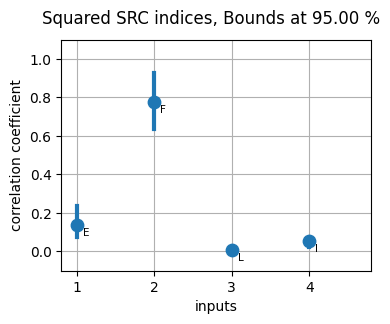

In [33]:
def plotSquaredSRCIndicesWithConfidenceIntervals(
    squaredSRCindices, input_names, alpha, squaredSRCBounds
):
    """Plot SRC indices with confidence bounds"""
    dim = squaredSRCindices.getDimension()
    lowerBounds = squaredSRCBounds.getLowerBound()
    upperBounds = squaredSRCBounds.getUpperBound()
    title = "Squared SRC indices, Bounds at %.2f %%" % ((1.0 - alpha) * 100)
    # Create graph
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        squaredSRCindices, input_names, title
    )
    # Fine tune the cloud
    palette = ot.DrawableImplementation.BuildDefaultPalette(1)
    cloud = graph.getDrawable(0)
    cloud.setColor(palette[0])
    graph.setDrawable(cloud, 0)
    # Add confidence bounds
    for i in range(dim):
        curve = ot.Curve([1 + i, 1 + i], [lowerBounds[i], upperBounds[i]])
        curve.setColor(palette[0])
        curve.setLineWidth(3.0)
        graph.add(curve)
    return graph


graph = plotSquaredSRCIndicesWithConfidenceIntervals(
    squaredSRCindices, input_names, alpha, squaredSRCBounds
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)}, scatter_kw={"s": 80.0})

## Solution de l'exercice 6 : Validation du modèle de régression linéaire

In [ ]:
# Considère à nouveau le modèle initial
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # in m
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # in m^4  # in cm^4
distributionI.setDescription(["I"])

X = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

# 1. Train
sample_size_train = 1000
sampleX_train = X.getSample(sample_size_train)
sampleY_train = g(sampleX_train)

myLeastSquares = ot.LinearLeastSquares(sampleX_train, sampleY_train)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
val = ot.MetaModelValidation(sampleY, responseSurface(sampleX))
r2 = val.computeR2Score()[0]
print("R2 = %.4f" % (r2))

# 2. Test
sample_size_test = 1000
sampleX_test = X.getSample(sample_size_test)
sampleY_test = g(sampleX_test)

val = ot.MetaModelValidation(sampleY_test, responseSurface(sampleX_test))
q2 = val.computeR2Score()[0]
print("Q2 = %.4f" % (q2))

R2 = 0.9773
Q2 = 0.9784


On observe peu de différence entre les coefficients $R^2$ et $Q^2$. On peut par conséquent être rassuré sur la qualité du métamodèle. La cause de cette faible différence est due au fait que l'on estime seulement $p + 1 = 5$ coefficients avec un plan d'expériences d'apprentissage de taille $n_{train} = 1000$. Par conséquent, on dispose d'une quantité relativement grande d'observations et le sur-apprentissage n'est pas un problème ici.

In [ ]:
predicted_outputs = responseSurface(sampleX)
residualsSample = sampleY - predicted_outputs
residualsSample.setDescription(["Residuals"])
sampleSize = sampleX.getSize()
input_dimension = sampleX.getDimension()
n_parameters = 1 + input_dimension
residuals_point = residualsSample.asPoint()
sigma_hat = math.sqrt(residuals_point.normSquare() / (sampleSize - n_parameters))
print("hat(sigma) = %.4f" % (sigma_hat))
noiseEstimated = ot.Normal(0.0, sigma_hat)

hat(sigma) = 0.6374


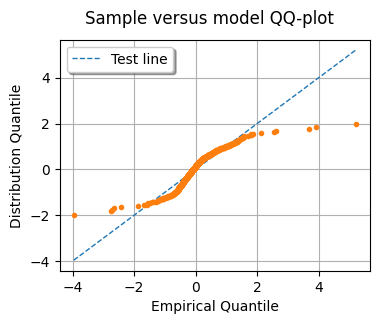

In [ ]:
QQ_plot = ot.VisualTest.DrawQQplot(residualsSample, noiseEstimated)
view = otv.View(QQ_plot, figure_kw={"figsize": (4.0, 3.0)})

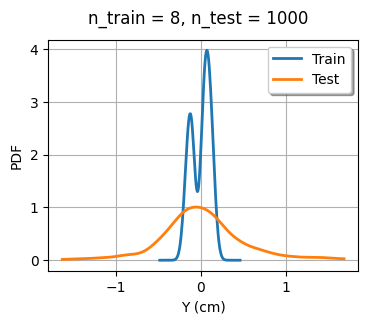

In [37]:
def computeTrainTestResiduals(sample_size_train, sample_size_test):
    sampleX_train = X.getSample(sample_size_train)
    sampleY_train = g(sampleX_train)

    myLeastSquares = ot.LinearLeastSquares(sampleX_train, sampleY_train)
    myLeastSquares.run()
    responseSurface = myLeastSquares.getMetaModel()
    val = ot.MetaModelValidation(sampleY_train, responseSurface(sampleX_train))
    residualsDistributionTrain = val.getResidualDistribution()

    # 2. Test
    sampleX_test = X.getSample(sample_size_test)
    sampleY_test = g(sampleX_test)

    val = ot.MetaModelValidation(sampleY_test, responseSurface(sampleX_test))
    residualsDistributionTest = val.getResidualDistribution()
    return residualsDistributionTrain, residualsDistributionTest


sample_size_train = 8
sample_size_test = 1000
residualsDistributionTrain, residualsDistributionTest = computeTrainTestResiduals(
    sample_size_train, sample_size_test
)
graph = residualsDistributionTrain.drawPDF()
graph.setLegends(["Train"])
curve = residualsDistributionTest.drawPDF()
curve.setLegends(["Test"])
graph.add(curve)
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph.setTitle("n_train = %d, n_test = %d" % (sample_size_train, sample_size_test))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Lorsque la taille de l'échantillon d'apprentissage est voisine du nombre de paramètres, alors le sur-apprentissage devient visible. Dans ce cas, la distribution des résidus issus de l'échantillon d'apprentissage est beaucoup plus resserrée que la distribution des résidus du métamodèle sur l'échantillon de test. 